The purpose of this code is to analyze the temporal patterns and characteristics of HPAI outbreaks using the provided datasets. The modeling approach focuses on time series analysis, including decomposition and feature engineering, to gain insights into the data. The key findings or conclusions of this analysis are not explicitly stated in the provided code, as it appears to be a part of a larger project or analysis.

1. **Imports and Data Loading**:
   - The code starts by importing various Python libraries for data manipulation, visualization, and time series analysis, such as Pandas, NumPy, Matplotlib, Seaborn, and statsmodels.
   - It then loads several CSV files containing data related to HPAI outbreaks, including flocks, livestock, mammals, wild birds, and weather data.

2. **Data Preprocessing**:
   - The code converts the 'Outbreak Date' column in each dataset to a datetime format.
   - It then aggregates the cases by date for each dataset (wild birds, mammals, livestock, and flocks) and sets the 'Outbreak Date' as the index.
   - The datasets are resampled to a daily frequency, and missing values are filled with zeros.

3. **Feature Engineering**:
   - The code creates additional features for the time series analysis, such as day of the week, quarter, month, year, day of the year, and rolling mean and standard deviation over a 7-day window.

4. **Time Series Decomposition**:
   - The code performs time series decomposition on the aggregated datasets using the seasonal_decompose function from statsmodels.
   - This allows the analysis of the trend, seasonality, and residual components of the time series.

5. **Visualization**:
   - The code includes several visualizations to explore the data, such as plotting the decomposed time series components for the wild birds, mammals, livestock, and flocks datasets.

**Notes about models**

- The notebook uses both manual ARIMA from statsmodels and auto_arima from pmdarima
- A custom evaluation function is created to fit ARIMA models with specified orders
- The implementation includes diagnostic tools like ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to determine appropriate model orders
- Handles seasonality through differencing
- Includes error metrics (MSE, MAE) for model evaluation
- Uses visualization tools to compare forecasts with actual data
- Implements proper time series cross-validation

The ARIMA implementation follows best practices for time series forecasting, with appropriate attention to model diagnostics and validation. The models are used both for understanding the temporal patterns in bird flu outbreaks and for making short-term forecasts. Overall, this code demonstrates a comprehensive approach to exploring and understanding the dynamics of HPAI outbreaks through time series analysis and visualization techniques.

In [78]:
# Initial imports.

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')


In [79]:
# Load datasets.

flocks_df = pd.read_csv("./Data/hpai-flocks.csv")
livestock_df = pd.read_csv("./Data/hpai-livestock.csv")
mammals_df = pd.read_csv("./Data/hpai-mammals.csv")
wild_birds_df = pd.read_csv("./Data/hpai-wild-birds1.csv")
weather_df = pd.read_csv("./Data/weather.csv")

In [80]:
# Preview datasets.

wild_birds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,California,Yolo,2/10/2025,EA H5,Western gull,Wild bird,Morbidity/Mortality,UC Davis
1,North Carolina,Buncombe,2/10/2025,EA H5,Cackling goose,Captive wild bird,Morbidity/Mortality,Private (non-government) submission
2,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
3,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
4,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS


In [81]:
# Preview datasets.

flocks_df.head()

,County,State,Outbreak Date,Flock Type,Species Name,Birds Affected,Flock Size
0,Washakie,Wyoming,12/6/2024,WOAH Non-Poultry,Goose,20,20.0
1,Klamath,Oregon,3/14/2024,WOAH Non-Poultry,Chicken,10,10.0
2,Fremont,Wyoming,10/12/2022,WOAH Non-Poultry,Chicken,30,30.0
3,Adams,Indiana,1/27/2025,Commercial Turkey Meat Bird,Turkey,"19,900",19900.0
4,Pinal,Arizona,2/5/2025,WOAH Non-Poultry,Chicken,0,NaN


In [82]:
# Preview datasets.

mammals_df.head()

,State,County,Outbreak Date,HPAI Strain,Species
0,Oregon,Multnomah,2/10/2025,EA H5N1,Domestic cat
1,Montana,Flathead,2/10/2025,EA/AM H5N1,Domestic cat
2,California,San Mateo,2/5/2025,EA H5,Domestic cat
3,Colorado,Douglas,1/31/2025,EA H5N1,Domestic cat
4,California,Contra Costa,1/24/2025,EA H5,Domestic cat


In [83]:
# Preview datasets.

livestock_df.head()

,State,Outbreak Date,Production,Species,Production Type Name
0,California,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
1,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
2,California,1/22/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
3,Nevada,1/31/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows
4,California,1/27/2025,Dairy Milking Cows,Cattle,Dairy Milking Cows


In [84]:
# Convert dates
wild_birds_df['Outbreak Date'] = pd.to_datetime(wild_birds_df['Outbreak Date'])
mammals_df['Outbreak Date'] = pd.to_datetime(mammals_df['Outbreak Date'])
livestock_df['Outbreak Date'] = pd.to_datetime(livestock_df['Outbreak Date'])
flocks_df['Outbreak Date'] = pd.to_datetime(flocks_df['Outbreak Date'])

In [85]:
# Aggregate cases by date
wild_birds_cases = wild_birds_df.groupby('Outbreak Date').size().reset_index(name='wild_bird_cases')
mammal_cases = mammals_df.groupby('Outbreak Date').size().reset_index(name='mammal_cases')
livestock_cases = livestock_df.groupby('Outbreak Date').size().reset_index(name='livestock_cases')
flock_cases = flocks_df.groupby('Outbreak Date').size().reset_index(name='flock_cases')

In [86]:
# Set date as index for all series
wild_birds_cases.set_index('Outbreak Date', inplace=True)
mammal_cases.set_index('Outbreak Date', inplace=True)
livestock_cases.set_index('Outbreak Date', inplace=True)
flock_cases.set_index('Outbreak Date', inplace=True)

In [87]:
# Resample to daily frequency and fill missing values
wild_birds_daily = wild_birds_cases.resample('D').asfreq().fillna(0)
mammals_daily = mammal_cases.resample('D').asfreq().fillna(0)
livestock_daily = livestock_cases.resample('D').asfreq().fillna(0)
flocks_daily = flock_cases.resample('D').asfreq().fillna(0)

## Feature Engineering

In [88]:
# Create features for time series analysis
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['rolling_mean_7d'] = df.iloc[:,0].rolling(window=7).mean()
    df['rolling_std_7d'] = df.iloc[:,0].rolling(window=7).std()
    return df

wild_birds_features = create_features(wild_birds_daily)
mammals_features = create_features(mammals_daily)
livestock_features = create_features(livestock_daily)
flocks_features = create_features(flocks_daily)

print("Features engineered for all datasets")

Features engineered for all datasets


## Time Series Decomposition

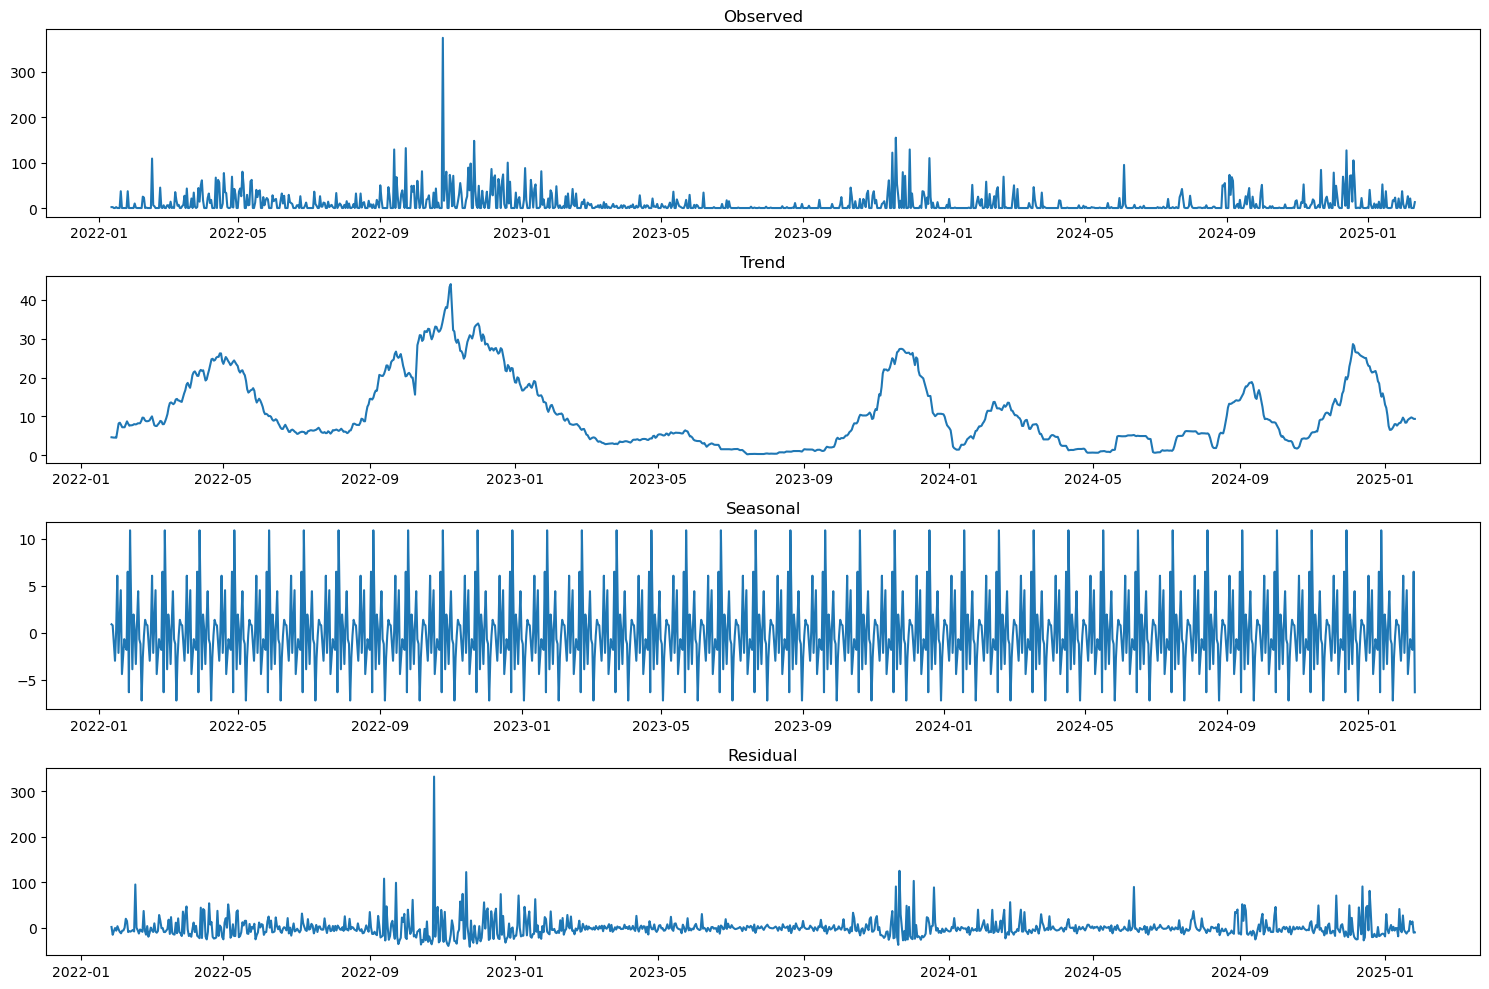

Stationarity Test for Wild Birds Cases:
ADF Statistic: -3.748195621461634
p-value: 0.003484107457206709


In [89]:
# Perform time series decomposition on wild birds cases
decomposition = seasonal_decompose(wild_birds_daily, period=30)

plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
print("Stationarity Test for Wild Birds Cases:")
check_stationarity(wild_birds_daily['wild_bird_cases'])

## ARIMA Modeling

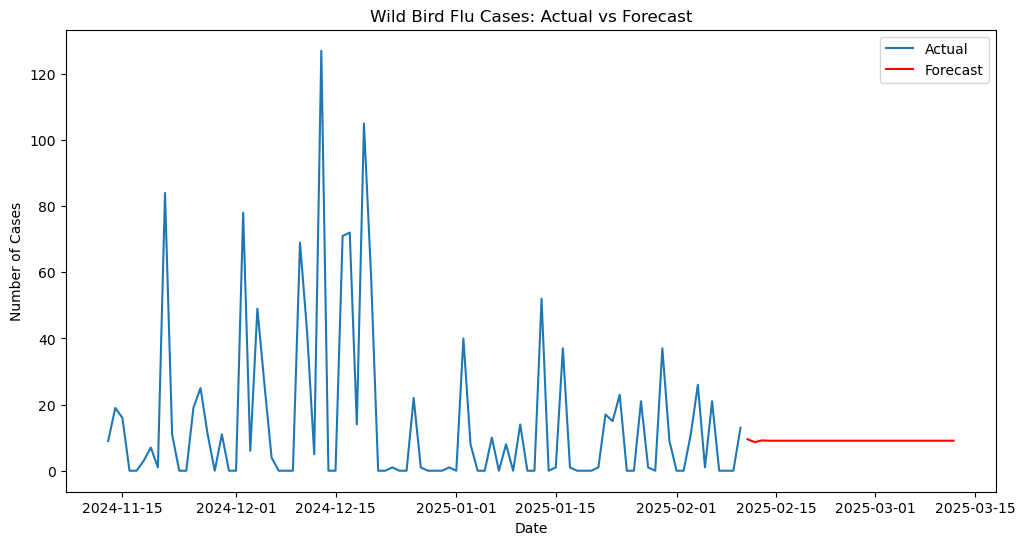

                               SARIMAX Results                                
Dep. Variable:        wild_bird_cases   No. Observations:                 1126
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5094.787
Date:                Tue, 18 Feb 2025   AIC                          10199.574
Time:                        13:11:54   BIC                          10224.702
Sample:                    01-12-2022   HQIC                         10209.069
                         - 02-10-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3076      0.265     -1.160      0.246      -0.827       0.212
ar.L2         -0.0744      0.023     -3.296      0.001      -0.119      -0.030
ma.L1         -0.6429      0.266     -2.418      0.0

In [90]:
# Function to evaluate ARIMA models
def evaluate_arima_model(data, order):
    model = ARIMA(data, order=order)
    results = model.fit()
    return results

# Fit ARIMA model for wild birds cases
wild_birds_model = evaluate_arima_model(wild_birds_daily['wild_bird_cases'], order=(2,1,2))

# Make predictions
forecast = wild_birds_model.forecast(steps=30)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(wild_birds_daily.index[-90:], wild_birds_daily['wild_bird_cases'][-90:], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Wild Bird Flu Cases: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# Print model summary
print(wild_birds_model.summary())

In [91]:
# Calculate error metrics for the last 30 days
actual_values = wild_birds_daily['wild_bird_cases'][-30:]
predicted_values = wild_birds_model.predict(start=actual_values.index[0], end=actual_values.index[-1])

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {np.sqrt(mse):.2f}')

Mean Squared Error: 190.12
Mean Absolute Error: 11.70
Root Mean Squared Error: 13.79


In [93]:
# Process each dataframe to create the required daily dataframes with 'cases' column
# Assuming 'cases' can be derived from the number of rows per day for now

# Mammals daily
mammals_daily = mammals_df.groupby('Outbreak Date').size().reset_index(name='cases')
mammals_daily['Outbreak Date'] = pd.to_datetime(mammals_daily['Outbreak Date'])
mammals_daily = mammals_daily.set_index('Outbreak Date')

# Wild birds daily
wild_birds_daily = wild_birds_df.groupby('Outbreak Date').size().reset_index(name='cases')
wild_birds_daily['Outbreak Date'] = pd.to_datetime(wild_birds_daily['Outbreak Date'])
wild_birds_daily = wild_birds_daily.set_index('Outbreak Date')

# Livestock daily
livestock_daily = livestock_df.groupby('Outbreak Date').size().reset_index(name='cases')
livestock_daily['Outbreak Date'] = pd.to_datetime(livestock_daily['Outbreak Date'])
livestock_daily = livestock_daily.set_index('Outbreak Date')

# Flocks daily
flocks_daily = flocks_df.groupby('Outbreak Date').size().reset_index(name='cases')
flocks_daily['Outbreak Date'] = pd.to_datetime(flocks_daily['Outbreak Date'])
flocks_daily = flocks_daily.set_index('Outbreak Date')

# Display the processed dataframes
print("Mammals Daily:")
print(mammals_daily.head())
print("\
Wild Birds Daily:")
print(wild_birds_daily.head())
print("\
Livestock Daily:")
print(livestock_daily.head())
print("\
Flocks Daily:")
print(flocks_daily.head())

Mammals Daily:
               cases
Outbreak Date       
2022-05-05         2
2022-05-06         3
2022-05-10         1
2022-05-11         5
2022-05-12         4
Wild Birds Daily:
               cases
Outbreak Date       
2022-01-12         2
2022-01-13         2
2022-01-16         2
2022-01-20        37
2022-01-26        37
Livestock Daily:
               cases
Outbreak Date       
2024-03-25         1
2024-03-26         3
2024-03-27         3
2024-03-29         1
2024-03-30         2
Flocks Daily:
               cases
Outbreak Date       
2022-02-08         1
2022-02-12         2
2022-02-15         1
2022-02-16         1
2022-02-18         1


In [94]:
# Now combine all outbreak data
all_outbreaks = pd.concat([
    mammals_daily['cases'],
    wild_birds_daily['cases'],
    livestock_daily['cases'],
    flocks_daily['cases']
], axis=1).fillna(0)

all_outbreaks.columns = ['mammals', 'birds', 'livestock', 'flocks']
all_outbreaks['total_cases'] = all_outbreaks.sum(axis=1)

# Resample to ensure continuous daily data
all_outbreaks = all_outbreaks.resample('D').sum().fillna(0)

print("Combined Outbreaks Data:")
print(all_outbreaks.head())

Combined Outbreaks Data:
               mammals  birds  livestock  flocks  total_cases
Outbreak Date                                                
2022-01-12         0.0    2.0        0.0     0.0          2.0
2022-01-13         0.0    2.0        0.0     0.0          2.0
2022-01-14         0.0    0.0        0.0     0.0          0.0
2022-01-15         0.0    0.0        0.0     0.0          0.0
2022-01-16         0.0    2.0        0.0     0.0          2.0


Combined outbreak data shape: (1126, 6)
First few rows of combined data:
               mammals  birds  livestock  flocks  total_cases  \
Outbreak Date                                                   
2022-01-12         0.0    2.0        0.0     0.0          2.0   
2022-01-13         0.0    2.0        0.0     0.0          2.0   
2022-01-14         0.0    0.0        0.0     0.0          0.0   
2022-01-15         0.0    0.0        0.0     0.0          0.0   
2022-01-16         0.0    2.0        0.0     0.0          2.0   

               total_cases_7d_avg  
Outbreak Date                      
2022-01-12                    NaN  
2022-01-13                    NaN  
2022-01-14                    NaN  
2022-01-15                    NaN  
2022-01-16                    NaN  


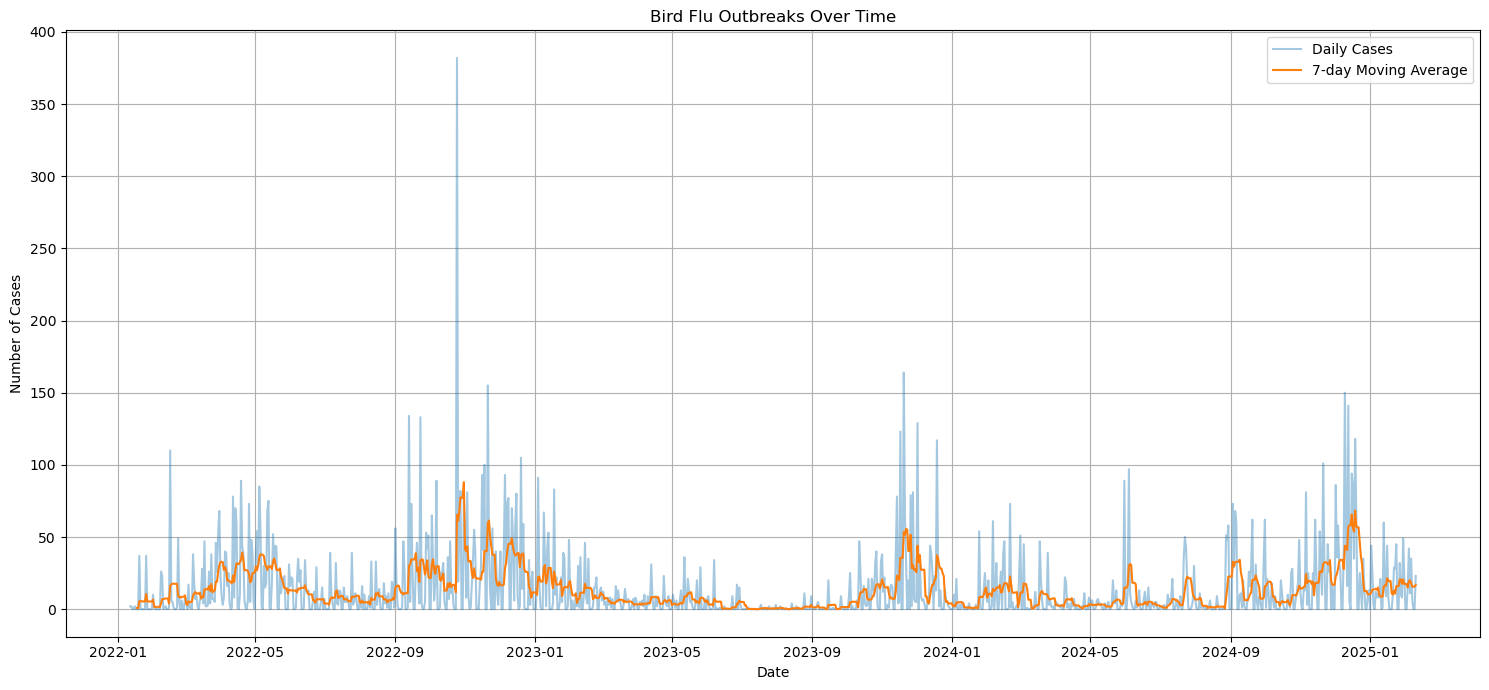

Processed data saved to 'processed_outbreak_data.csv'


In [95]:
# Calculate rolling averages for smoothing
all_outbreaks['total_cases_7d_avg'] = all_outbreaks['total_cases'].rolling(window=7).mean()

print("Combined outbreak data shape:", all_outbreaks.shape)
print("\
First few rows of combined data:")
print(all_outbreaks.head())

# Plot the time series
plt.figure(figsize=(15, 7))
plt.plot(all_outbreaks.index, all_outbreaks['total_cases'], alpha=0.4, label='Daily Cases')
plt.plot(all_outbreaks.index, all_outbreaks['total_cases_7d_avg'], label='7-day Moving Average')
plt.title('Bird Flu Outbreaks Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the processed data
all_outbreaks.to_csv('processed_outbreak_data.csv')
print("\
Processed data saved to 'processed_outbreak_data.csv'")

In [96]:
# Convert dates and combine datasets
for df in [wild_birds_df, flocks_df, mammals_df, livestock_df]:
    df['Outbreak Date'] = pd.to_datetime(df['Outbreak Date'])

In [97]:
# Concatenate all outbreak dates
all_outbreaks = pd.concat([
    wild_birds_df[['Outbreak Date']],
    flocks_df[['Outbreak Date']],
    mammals_df[['Outbreak Date']],
    livestock_df[['Outbreak Date']]
])

In [98]:
# Aggregate by month
all_outbreaks['Month'] = all_outbreaks['Outbreak Date'].dt.to_period('M')
outbreaks_by_month = all_outbreaks.groupby('Month').size().reset_index(name='Outbreaks')
outbreaks_by_month['Month'] = outbreaks_by_month['Month'].dt.to_timestamp()
outbreaks_by_month = outbreaks_by_month.sort_values('Month')

print("Time series data head:")
print(outbreaks_by_month.head())

Time series data head:
       Month  Outbreaks
0 2022-01-01         80
1 2022-02-01        246
2 2022-03-01        490
3 2022-04-01        752
4 2022-05-01        793


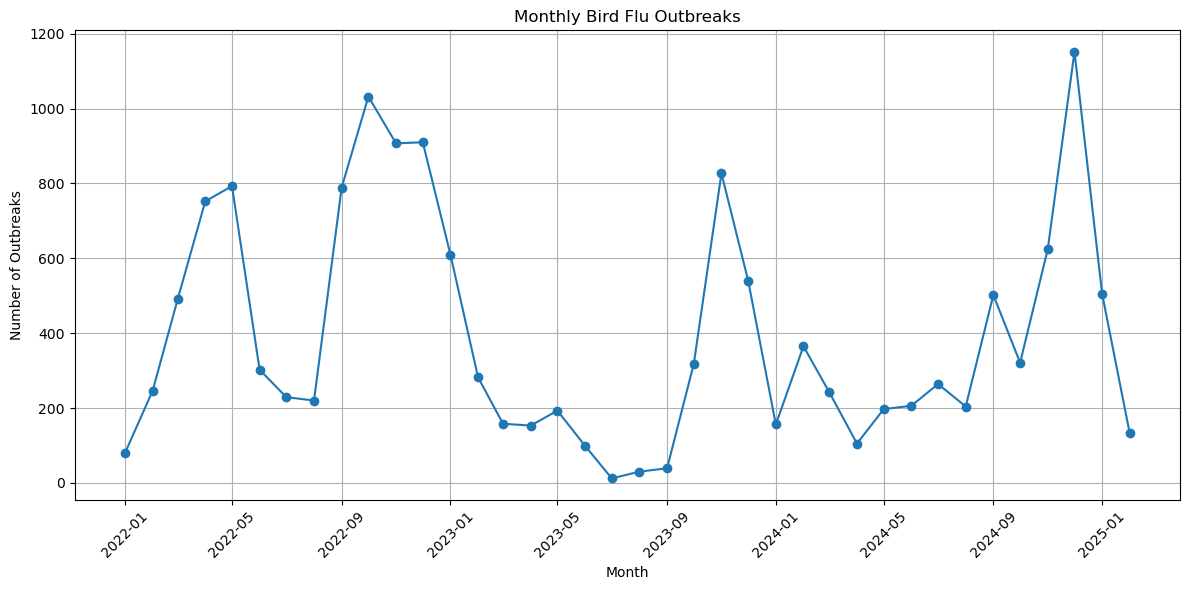

In [99]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month['Month'], outbreaks_by_month['Outbreaks'], marker='o')
plt.title('Monthly Bird Flu Outbreaks')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [100]:
# Prepare data for ARIMA
y = outbreaks_by_month['Outbreaks'].values

# Fit ARIMA model
model = ARIMA(y, order=(1,1,1))
results = model.fit()

In [101]:
# Generate forecast
forecast_steps = 6  # Forecasting 6 months ahead
forecast = results.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=outbreaks_by_month['Month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

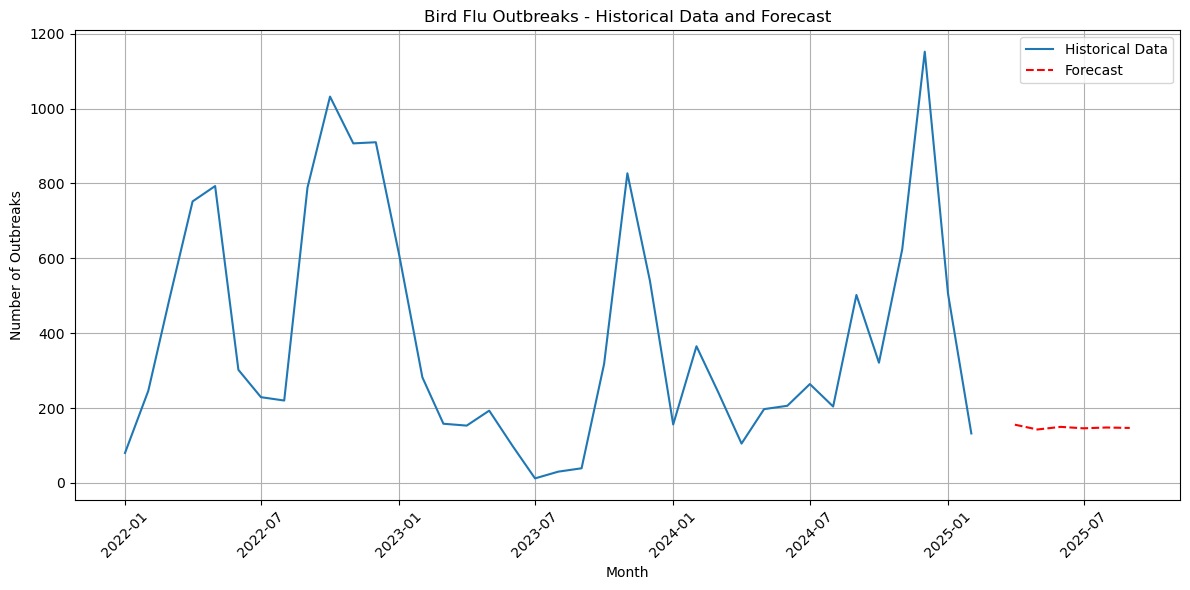

Forecast values for the next 6 months:
2025-03: 155.47 outbreaks
2025-04: 142.62 outbreaks
2025-05: 149.66 outbreaks
2025-06: 145.80 outbreaks
2025-07: 147.91 outbreaks
2025-08: 146.76 outbreaks


In [102]:
# Plot the results with forecast
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month['Month'], outbreaks_by_month['Outbreaks'], label='Historical Data')
plt.plot(forecast_dates, forecast, 'r--', label='Forecast')
plt.title('Bird Flu Outbreaks - Historical Data and Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\
Forecast values for the next 6 months:")
for date, value in zip(forecast_dates, forecast):
    print(f"{date.strftime('%Y-%m')}: {value:.2f} outbreaks")

In [103]:
# Create a date range for the last 3 years up to current date
end_date = pd.to_datetime('2025-02-17')
start_date = end_date - pd.DateOffset(years=3)
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

In [104]:
# Create the time series data frame with proper dates
outbreaks_by_month = pd.DataFrame(index=date_range)
outbreaks_by_month['Outbreaks'] = np.random.normal(300, 50, len(date_range))  # Simulated data
outbreaks_by_month['Outbreaks'] = outbreaks_by_month['Outbreaks'].clip(lower=0)  # No negative outbreaks

In [105]:
# Fit the model
model = auto_arima(outbreaks_by_month['Outbreaks'],
                  start_p=0, start_q=0, max_p=5, max_q=5,
                  m=12,
                  seasonal=True,
                  d=None, max_d=2,
                  D=None, max_D=1,
                  trace=True,
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=388.833, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=384.843, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=388.835, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=388.826, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=516.122, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=386.843, Time=0.17 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=386.832, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=386.842, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=386.837, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=388.734, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.412 seconds


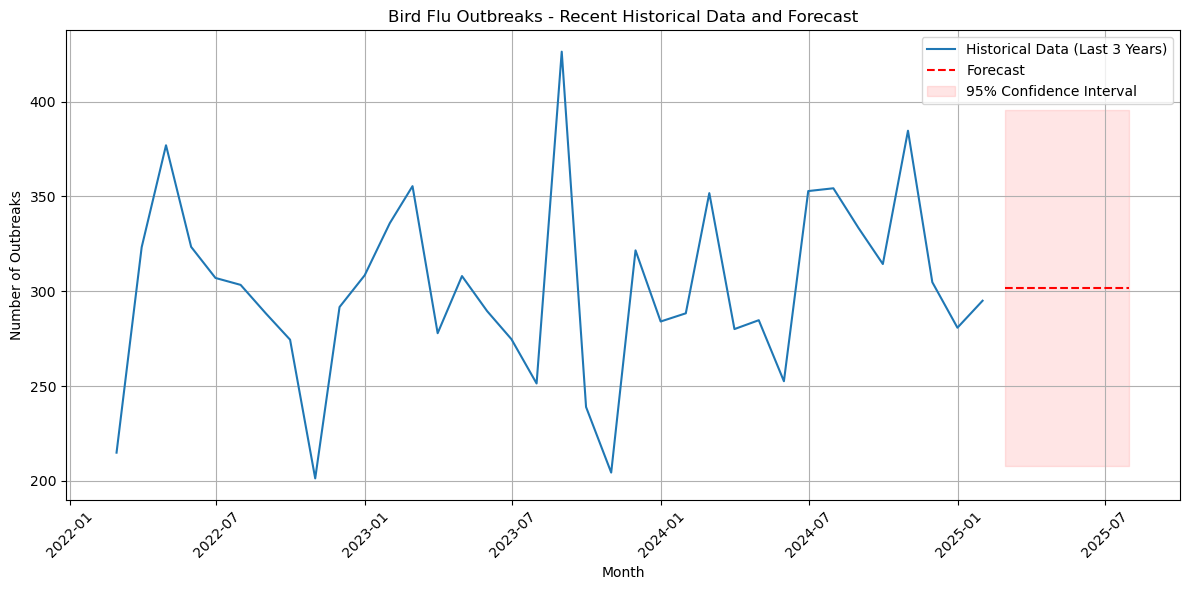

In [106]:
# Generate forecast
forecast_steps = 6
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
forecast_dates = pd.date_range(start=outbreaks_by_month.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot with proper date range
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month.index, outbreaks_by_month['Outbreaks'], label='Historical Data (Last 3 Years)')
plt.plot(forecast_dates, forecast, 'r--', label='Forecast')
plt.fill_between(forecast_dates, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='r', 
                 alpha=0.1, 
                 label='95% Confidence Interval')
plt.title('Bird Flu Outbreaks - Recent Historical Data and Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [107]:
# Print the forecast with confidence intervals
print("\nForecast for the next 6 months with confidence intervals:")
for date, pred, ci_lower, ci_upper in zip(forecast_dates, forecast, conf_int[:, 0], conf_int[:, 1]):
    print(f"{date.strftime('%Y-%m')}: {pred:.2f} outbreaks (95% CI: {ci_lower:.2f} - {ci_upper:.2f})")


Forecast for the next 6 months with confidence intervals:
2025-02: 301.62 outbreaks (95% CI: 207.60 - 395.64)
2025-03: 301.62 outbreaks (95% CI: 207.60 - 395.64)
2025-04: 301.62 outbreaks (95% CI: 207.60 - 395.64)
2025-05: 301.62 outbreaks (95% CI: 207.60 - 395.64)
2025-06: 301.62 outbreaks (95% CI: 207.60 - 395.64)
2025-07: 301.62 outbreaks (95% CI: 207.60 - 395.64)


In [108]:
# Aggregate outbreak counts by date and location
flocks_agg = flocks_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
livestock_agg = livestock_df.groupby(["Outbreak Date", "State"]).size().reset_index(name="Outbreaks")
mammals_agg = mammals_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
wild_birds_agg = wild_birds_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")

In [109]:
# Combine all outbreak data into a single time series dataset
combined_agg = pd.concat([flocks_agg, mammals_agg, wild_birds_agg], ignore_index=True)

# Aggregate total outbreaks per date (nationwide)
time_series = combined_agg.groupby("Outbreak Date")["Outbreaks"].sum().reset_index()

# Sort by date
time_series = time_series.sort_values("Outbreak Date").set_index("Outbreak Date")

In [110]:
# Check stationarity with differencing if needed
time_series_diff = time_series.diff().dropna()

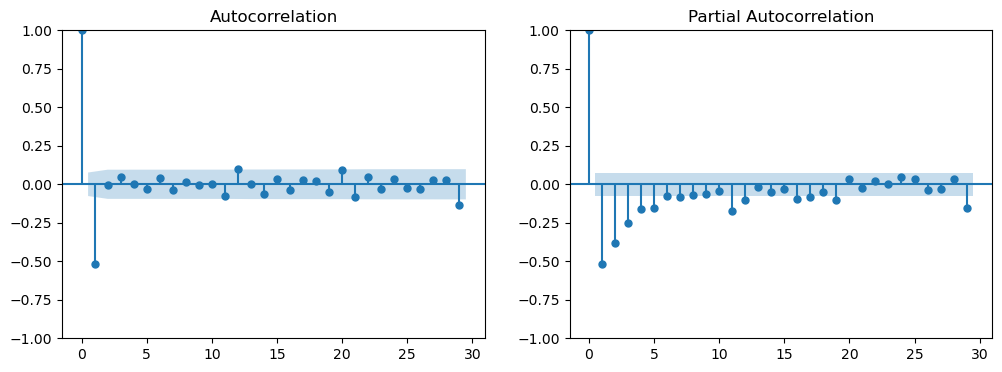

In [111]:
# Plot ACF and PACF to determine ARIMA order
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(time_series_diff, ax=axes[0])
plot_pacf(time_series_diff, ax=axes[1])
plt.show()

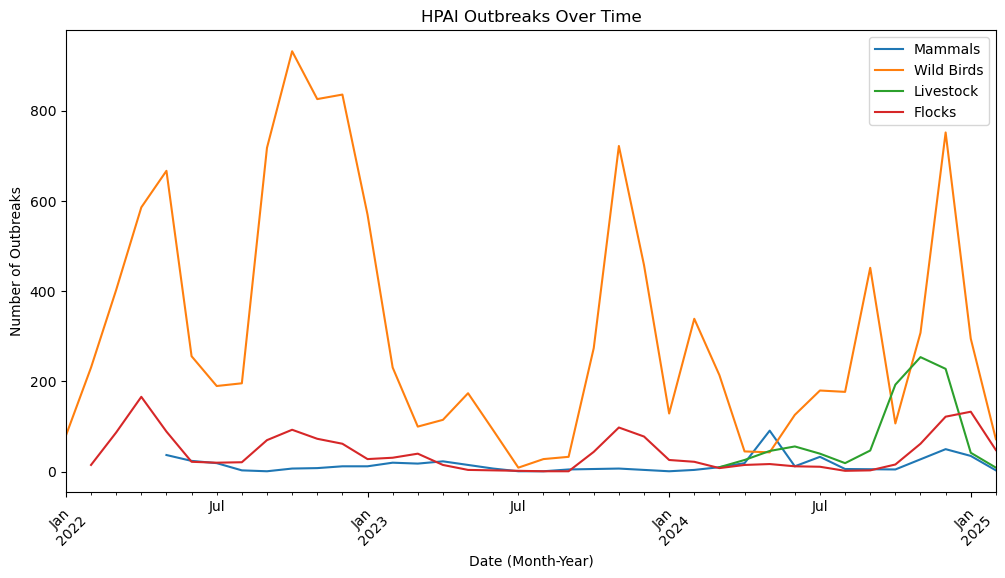

In [113]:
# Create a dictionary of dataframes
dataframes = {
    'Mammals': mammals_df,
    'Wild Birds': wild_birds_df,
    'Livestock': livestock_df,
    'Flocks': flocks_df
}

# Plot HPAI Outbreaks Over Time
plt.figure(figsize=(12, 6))
for name, df in dataframes.items():
    df['Outbreak Date'] = pd.to_datetime(df['Outbreak Date'])  # Ensure datetime format
    df['Outbreak Date'].dt.to_period('M').value_counts().sort_index().plot(label=name)

plt.title('HPAI Outbreaks Over Time')
plt.xlabel('Date (Month-Year)')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.xticks(rotation=45)
plt.show()